# Fractal 
In This notebook we will indemayer systems [L-systems](https://en.wikipedia.org/wiki/L-system) to build fractals

## Matplotlib
we will be using matplotlib to draw the lines 

In [1]:
# to make your plot outputs appear and be stored within the notebook. 
%matplotlib inline 

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')  # Use some nicer default colors

Now `plt.plot` will help for drawing lines 
It needs to lists to be passed as args and will plot them
we may need to change this to pairs 

In [3]:
def plot_coords(coords):
    '''takes a pair and converts it lists that plt accepts'''
    # Ensures equal aspect ratio.
    plt.axes().set_aspect('equal', 'datalim')
    # Converts a list of coordinates into 
    # lists of X and Y values, respectively.
    X, Y = zip(*coords)
    # Draws the plot.
    plt.plot(X, Y);

In [4]:
def plot_coords_bare(coords):
    '''remove axis markers'''
    plot_coords(coords)
    plt.axis('off')

Ok lets test, also note to draw not connected lines, we may use `nan`

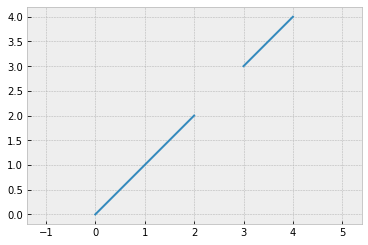

In [5]:
nan = float('nan')

plot_coords([
    (0,0),
    (2,2),
    (nan, nan),
    (3,3),
    (4,4)
])

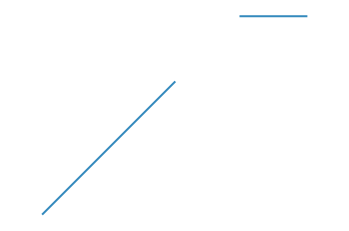

In [6]:
plot_coords_bare([
    (0,0),
    (2,2),
    (nan, nan),
    (3,3),
    (4,3)
])

## Turtle Graphics
Let's simulate a "turtle" that walks on the screen, tracing its route
so instead of giving the coords we will tell the turtle where to go

we will also need to rotate the lines so we need `sin` and `cos`

In [7]:
from math import sin, cos, pi
DEGREES_TO_RADIANS = pi / 180

Let's define the instrcutions that we give to the turtle 

`F` move forward one unit and draw the trace 
`f` move forward one unit but draw the trace  
`+` rotate counter-clockwise 
`-`  rotate clockwise

Example `F-F+F+F+f+F+F+F-F'`

In [8]:
def turtle_to_coords(turtle_program, turn_amount=45):
    # The state variable tracks the current location and angle of the turtle.
    # The turtle starts at (0, 0) facing up (90 degrees).
    state = (0.0, 0.0, 90.0)
    
    # Throughout the turtle's journey, we "yield" its location. These coordinate
    # pairs become the path that plot_coords draws.
    yield (0.0, 0.0)
    
    # Loop over the program, one character at a time.
    for command in turtle_program:
        x, y, angle = state
        
        if command in 'Ff':      # Move turtle forward
            state = (x - cos(angle * DEGREES_TO_RADIANS),
                     y + sin(angle * DEGREES_TO_RADIANS),
                     angle)
            
            if command == 'f':
                # Insert a break in the path so that
                # this line segment isn't drawn.
                yield (float('nan'), float('nan'))
                
            yield (state[0], state[1])
                        
        elif command == '+':     # Turn turtle clockwise without moving
            state = (x, y, angle + turn_amount)
            
        elif command == '-':     # Turn turtle counter-clockwise without moving
            state = (x, y, angle - turn_amount)
            
        # Note: We silently ignore unknown commands

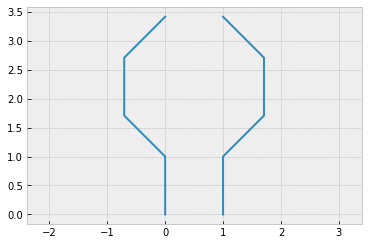

In [9]:
plot_coords(turtle_to_coords('F-F+F+F+f+F+F+F-F'))

perfect we may change the rotaion angle by changing turn amount 

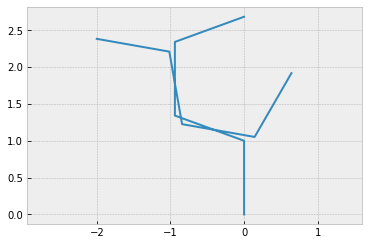

In [10]:
plot_coords(turtle_to_coords('F-F+F+F+f+F+F+F-F', turn_amount=70))

## Transformations 

One simple string transformation is to take an initial string (which we call the axiom) and one or more transformation rules. Each transformation rule specifies a character and a string. Each time the rule's character appears in the axiom, it is replaced with the rule's string. 

For example
- `a -> abb`
- `c -> bba`


In [11]:
def transform_sequence(sequence, transformations):
    return ''.join(transformations.get(c, c) for c in sequence)
transform_sequence('acc', {'a' : 'abb', 'c' : 'bba'})

'abbbbabba'

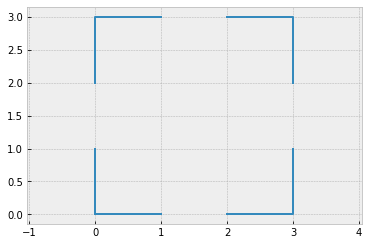

In [12]:
plot_coords(turtle_to_coords(transform_sequence('FFFF', {'F': 'FfF++'})))

As we can see we may think of transofrmations as loops, it will help us alot!

In [13]:
def transform_multiple(sequence, transformations, iterations):
    for _ in range(iterations):
        sequence = transform_sequence(sequence, transformations)
    return sequence

In [14]:
transform_multiple('acc', {'a' : 'abb', 'c' : 'bba'}, 2)

'abbbbbbabbbbabb'

Let's see how powerful is this

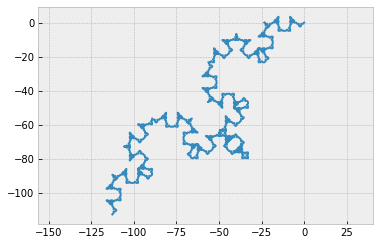

In [15]:
plot_coords(turtle_to_coords(transform_multiple('F', {'F': '+F+F--F+F'}, 5)))

We can also use this to draw a [Hilbert curve](https://en.wikipedia.org/wiki/Hilbert_curve)

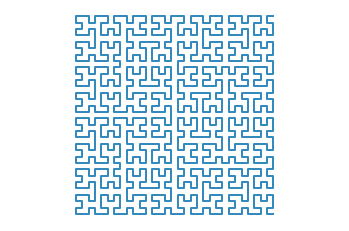

In [16]:
plot_coords_bare(turtle_to_coords(transform_multiple('L', {
    'L': '-RF+LFL+FR-',
    'R': '+LF-RFR-FL+'
}, 5), 90))

## Branching Turtle Graphics

t's hard to represent the sort of branching that a tree does with a continuous path.

In order to represent tree-like branching, I'll add two new turtle commands: '[' and ']'. One way to think of these commands is that they give our simulated turtle a sense of memory. The '[' command tells the turtle to stay still but remember its current location (including the angle). The ']' command tells it to go to the last remembered location. Once the turtle goes back to a remembered location it promptly forgets about it, so then the next time ']' is called it goes to the last remembered location before that. A consequence of this "forgetting" is that the each ']' must match up with a prior '[', otherwise you are essentially asking the turtle to return to more positions than you told it to remember!

In [17]:
def branching_turtle_to_coords(turtle_program, turn_amount=45, inital=90):
    saved_states = list()
    state = (0, 0, inital)
    yield (0, 0)

    for command in turtle_program:
        x, y, angle = state

        if command.lower() in 'abcdefghij':        # Move forward (matches a-j and A-J)
            state = (x - cos(angle * DEGREES_TO_RADIANS),
                     y + sin(angle * DEGREES_TO_RADIANS),
                     angle)
            
            if command.islower():                  # Add a break in the line if command matches a-j
                yield (float('nan'), float('nan'))

            yield (state[0], state[1])

        elif command == '+':                       # Turn clockwise
            state = (x, y, angle + turn_amount)

        elif command == '-':                       # Turn counterclockwise
            state = (x, y, angle - turn_amount)

        elif command == '[':                       # Remember current state
            saved_states.append(state)

        elif command == ']':                       # Return to previous state
            state = saved_states.pop()
            yield (float('nan'), float('nan'))
            x, y, _ = state
            yield (x, y)

        # Note: We silently ignore unknown commands

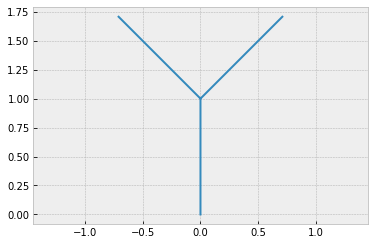

In [18]:
plot_coords(branching_turtle_to_coords('F[-F]+F', 45))

Recall that the turtle starts at `(0, 0)` facing up. The first `F` moves the turtle to `(0, 1)`, still pointing up. Then the `'['` command tells the turtle to **remember its current position**. The turtle then does a counter-clockwise rotation, goes forward, and *resumes the remembered location*. Then it rotates clockwise (remember, when it returned to its remembered position at `(0, 1)` it returned to the angle it remembered as well), and goes forward again.

Now that we have everything we need for an L-system, let's wrap it up in a function called `l_plot` that runs through all the steps in generating a graphic. To review, that's:
1. Iteratively apply the string rewriting transformations a given number of times.
2. Convert the turtle program to a list of coordinates.
3. Draw the result.

In [19]:
def l_plot(axiom, transformations, iterations=0, angle=45, intial=90):
    turtle_program = transform_multiple(axiom, transformations, iterations)
    coords = branching_turtle_to_coords(turtle_program, angle, inital=intial)
    plot_coords_bare(coords) # bare_plot removes the axis labels

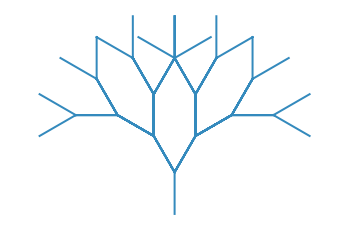

In [20]:
l_plot('F', {'F': 'F[-F][+F]'}, 4, 30)

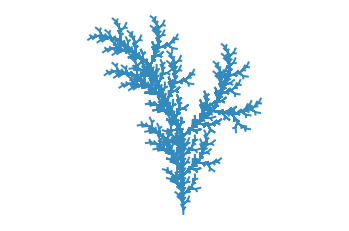

In [21]:
l_plot('F', {'F': 'FF[++F][-FF]'}, 5, 25)

We're on the right track. A technique to make things look more tree-like is to make the lines closer to the root "longer". One way to do this is to use a rule like `F → FF`

This has the effect of making lines that appear *earlier* get *longer*. To see what I mean, look at the behavior of the following rule over several iterations:

In [22]:
for i in range(5):
    print(f'{i}: ',
          transform_multiple('A', {'A': 'F+A'}, i))

0:  A
1:  F+A
2:  F+F+A
3:  F+F+F+A
4:  F+F+F+F+A


In [23]:
for i in range(5):
    print(f'{i}: ',
          transform_multiple('A', {'A': 'F+A', 'F': 'FF'}, i))

0:  A
1:  F+A
2:  FF+F+A
3:  FFFF+FF+F+A
4:  FFFFFFFF+FFFF+FF+F+A


In [ ]:
l_plot('A', {'F': 'FF', 'A': 'F[+AF-[A]--A][---A]'}, 500, 22.5)

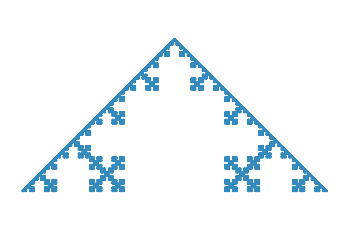

In [25]:
l_plot('F', {'F': 'F+F-F-F+F'}, 8, 90, 0)

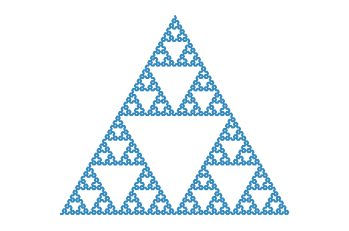

In [26]:
l_plot('A', {'A': 'B-A-B', 'B':'A+B+A'}, 7, 60, 180)

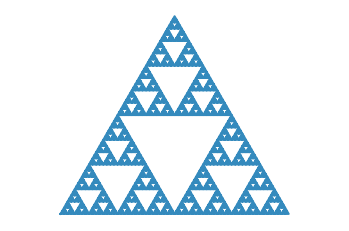

In [27]:
l_plot('F-G-G', {'F': 'F-G+F+G-F', 'G':'GG'}, 6, 120, 180)